# how simuPOP can be extremely flexible on demographic modeling..

**simulation**

1. male age-structured population 이 나이에 따라 다른 fecundity 를 가진다.
2. different maximum litter size for females
3. simulate multiallelic loci

--- In the middle of the simulation, we will remove all older females.

## 여기서는 각 성별에서 three age groups 이 아래와 같은 조건하에 있다고 가정하고 시작한다.

1. 첫번째 그룹은 reproduce 하지못하는 그룹(infant)이며 나머지 나이가 많은 두그룹은 repoduce 가능.
2. 남자 2번 그룹은 3번그룹보다 2배의 mating chance 가 있다고 가정.
3. 여자 2번 그룹은 다산성(자녀가 많다) 이고 여자 3번 그룹은 자식 1명만 낳는다.
5. 남자 1번그룹은 2,3 번그룹으로 이동할 때 80퍼센트만 살아남는다.
6. 여자 1번그룹은 2,3 번그룹으로 이동할때 90퍼센트만 살아남는다.

# Effective population size

definition : 실제 population 에서 LOH 가 일어나는 rate 와 비슷한 rate 를 지니니는 ideal population 의 size.

example) genetic drift  

Genetic drift 는 population size 와 직접적으로 연관되어 있다. (small = more drift, large = less drift).
The triangle of drift, mutation and migration is the big three for the purposes of understanding a neutral theory approach to population genetic structure.

In [1]:
from __future__ import division
from collections import defaultdict, OrderedDict
from copy import deepcopy
import random

import numpy as np
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt

import simuPOP as sp
%matplotlib inline

simuPOP Version 1.1.6 : Copyright (c) 2004-2011 Bo Peng
Revision 4972 (May  1 2015) for Python 2.7.9 (64bit, 1thread)
Random Number Generator is set to mt19937 with random seed 0xbc5f18c4ec757d84.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


/home/seung-hyun/anaconda/envs/bioinformatics/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# kill 함수정의.

def kill(pop):
    kills = []
    for i in pop.individuals():
        if i.sex() == 1:
            cut = pop.dvars().survival_male[int(i.age)]
        else:
            cut = pop.dvars().survival_female[int(i.age)]
            if pop.dvars().gen > pop.dvars().cut_gen and i.age == 2: # certain generation 후에는 2살인(age) all female 을 kill.
                cut = 0
        if random.random() > cut:
            kills.append(i.ind_id)
    pop.removeIndividuals(IDs=kills)
    return True

In [3]:
# Parent 를 random 이 아닌 choose 한다. 


def choose_parents(pop):
    #name convention required
    fathers = []
    mothers = []

    for ind in pop.individuals():
        if ind.sex() == 1:
            fathers.extend([ind] * pop.dvars().male_age_fecundity[int(ind.age)]) # Males of age two get two entries (후에 defined)
        else:
            ind.num_kids = 0
            mothers.append(ind)
    while True:
        father = random.choice(fathers)
        mother_ok = False
        while not mother_ok:
            mother = random.choice(mothers)
            if mother.num_kids < pop.dvars().max_kids[int(mother.age)]:
                mother.num_kids += 1
                mother_ok = True
        yield father, mother
        
def calc_demo(gen, pop):
    if gen > pop.dvars().cut_gen:
        add_females = len([ind for ind in pop.individuals([0, 2]) if ind.sex() == 2])
    else:
        add_females = 0
    return pop_size + pop.subPopSize([0, 3]) + add_females

In [4]:
# CloneMating : copy all individuals to the next cycle
# HomoMating will add a few extra individuals according to the choice of parents in the preceding function.

mating_scheme = sp.HeteroMating([
    sp.HomoMating(
        sp.PyParentsChooser(choose_parents),
        sp.OffspringGenerator(numOffspring=1, ops=[
            sp.MendelianGenoTransmitter(), sp.IdTagger()]),
        weight=1),
    sp.CloneMating(weight=-1)],
    subPopSize=calc_demo)

In [5]:
# simuPOP allows you to split your population into virtual subgroups
# we will have virtual subpopulations divided by age.


pop_size = 300
num_loci = 50
num_alleles = 10
num_gens = 90
cut_gen = 50
#max_age = 3
max_kids = [0, 0, float('inf'), 1] # Females 는 그들의 나이의 따라 최대한의 자식을 갖는다.
male_age_fecundity = [0, 0, 2, 1]
survival_male = [1, 0.8, 0.8, 0]
survival_female = [1, 0.9, 0.9, 0]

In [6]:
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['age', 'ind_id', 'num_kids'])
pops.setVirtualSplitter(sp.InfoSplitter(field='age', cutoff=[1, 2, 3])) # virtual population => subpopulation

In [7]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

In [8]:
def init_age(pop):
    pop.dvars().male_age_fecundity = male_age_fecundity
    pop.dvars().survival_male = survival_male
    pop.dvars().survival_female = survival_female
    pop.dvars().max_kids = max_kids
    pop.dvars().cut_gen = cut_gen
    return True

In [9]:
def init_accumulators(pop, param):
    accumulators = param
    for accumulator in accumulators:
        pop.vars()[accumulator] = []
    return True

def update_pyramid(pop):
    pyr = defaultdict(int)
    for ind in pop.individuals():
        pyr[(int(ind.age), int(ind.sex()))] += 1
    pop.vars()['age_pyramid'].append(pyr)
    return True

# We compute an effective population size (Ne) estimator based on linkage disequilibrium.
# Ne estimation 은 single cohort 에서만 가능하기 때문에  0 subpopuation (infant group) 에서만 계산된다.

def update_ldne(pop):
    pop.vars()['ldne'].append(pop.dvars().Ne_LD[0.05]) 
    return True

In [10]:
init_ops['Sex'] = sp.InitSex()
init_ops['ID'] = sp.IdTagger()
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['ldne', 'age_pyramid'])
init_ops['Freq'] = sp.InitGenotype(freq=[1 / num_alleles] * num_alleles)
init_ops['Age-prepare'] = sp.PyOperator(init_age)
init_ops['Age'] = sp.InitInfo(lambda: random.randint(0, len(survival_male) - 1), infoFields='age')
pre_ops['Kill'] = sp.PyOperator(kill)
pre_ops['Age'] = sp.InfoExec('age += 1')
pre_ops['pyramid_accumulator'] = sp.PyOperator(update_pyramid)
post_ops['Ne'] = sp.Stat(effectiveSize=sp.ALL_AVAIL, subPops=[[0, 0]], vars=['Ne_LD'])
post_ops['Ne_accumulator'] = sp.PyOperator(update_ldne)
post_ops['count'] = sp.PyEval(r'"gen %d, size %d\n" % (gen, pop.popSize())', exposePop='pop')

In [11]:
# simulation for 90 generations,
# start killing females of age two at 50 generation
# First 10 generation 은 burn-in 된것으로 생각.
# 10 allels
# Age-pyramid function 을 이용하여 age-structure 구조를 계속해서 저장한다. 

sim = sp.Simulator(pops, rep=1)
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)

(90L,)

In [12]:
ld_ne = sim.population(0).dvars().ldne
pyramid = sim.population(0).dvars().age_pyramid

/home/seung-hyun/anaconda/envs/bioinformatics/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


TypeError: boxplot() got multiple values for keyword argument 'widths'

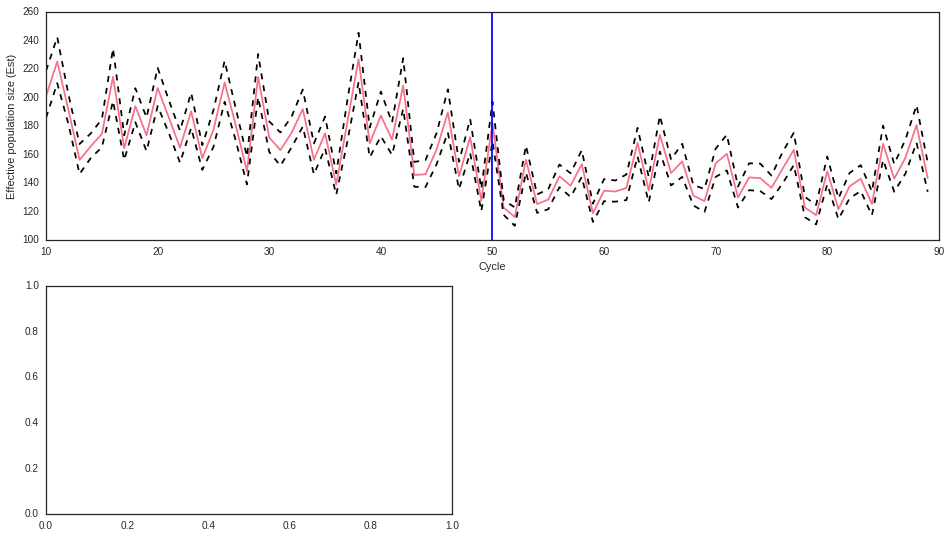

In [13]:
# plot을 해보면 세로축은 Ne estimation  가로축은 time = generation with age-pyramid?

# The top chart shows the Ne estimation (including 5 and 95 percent confidence intervals in dashed lines).
# The bottom charts shows the distribution of number of individuals per age group (1 to 3) and sex.

# 왼쪽은 old female 을 추려내기전, 오른쪽은 추려낸후 Plot.

# top chart 의 blue line 부터 old-aged female 이 추려지거, effective population size 가 감소한다.
# bottom chart 의 세로축은 사람수 가로축은 age group 이며 Pink 는 남자, brown은 여자이다. 

sns.set_palette('husl')

fig = plt.figure(figsize=(16, 9))
ax_ldne = fig.add_subplot(211)
ax_ldne.plot([x[0] for x in ld_ne[10:]])
ax_ldne.plot([x[1] for x in ld_ne[10:]], 'k--')
ax_ldne.plot([x[2] for x in ld_ne[10:]], 'k--')
ax_ldne.set_xticks(range(0, 81, 10))
ax_ldne.set_xticklabels([str(x) for x in range(10, 91, 10)])
ax_ldne.axvline(cut_gen - 10)
ax_ldne.set_xlabel('Cycle')
ax_ldne.set_ylabel('Effective population size (Est)')

def plot_pyramid(ax_bp, pyramids):
    bp_data = [([], []) for group in range(3)]
    for my_pyramid in pyramids:
        for (age, sex), cnt in my_pyramid.items():
            bp_data[age - 1][sex - 1].append(cnt)
    for group in range(3):
        bp = sns.boxplot(bp_data[group], positions=[group * 3 + 1, group * 3 + 2], widths=0.6, ax=ax_bp)
        ax_bp.text(1 + 3 * group, 90, 'M', va='top', ha='center')
        ax_bp.text(2 + 3 * group, 90, 'F', va='top', ha='center')
    ax_bp.set_xlim(0, 9)
    ax_bp.set_ylim(20, 90)
    ax_bp.set_xticklabels(['1', '2', '3'])
    ax_bp.set_xticks([1.5, 4.5, 7.5])
    ax_bp.legend()

pre_decline = pyramid[10:50]
post_decline = pyramid[51:]


ax_bp = fig.add_subplot(2, 2, 3)
plot_pyramid(ax_bp, pre_decline)


ax_bp = fig.add_subplot(2, 2, 4)
plot_pyramid(ax_bp, post_decline)

In [14]:
print post_decline[10]

defaultdict(<type 'int'>, {(1, 2): 52, (3, 1): 33, (1, 1): 72, (2, 1): 57, (2, 2): 55})
